# Task 2: Lookalike Model


This notebook implements a Lookalike Model to recommend the top 3 similar customers for the first 20 customers (CustomerID: C0001 - C0020). The recommendations are based on both customer profile information and transaction history.


## Problem Statement
The objective is to:
1. Build a model that takes a customer's information as input and recommends 3 similar customers.
2. Use both customer and product information to calculate similarity.
3. Provide recommendations with similarity scores for the first 20 customers.
4. Save the recommendations in a CSV file (`Lookalike.csv`).


## Dataset Overview
The following datasets were used:
1. `Customers.csv`: Contains customer details such as ID, region, and signup date.
2. `Products.csv`: Provides product information such as product name, category, and price.
3. `Transactions.csv`: Includes transaction details such as quantity purchased, transaction date, and total value.


## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


## Load the data

In [2]:
customers=pd.read_csv(r"C:\Users\Gunolla Srinivas\Downloads\Customers.csv")
products=pd.read_csv(r"C:\Users\Gunolla Srinivas\Downloads\Products.csv")
transactions=pd.read_csv(r"C:\Users\Gunolla Srinivas\Downloads\Transactions.csv")

In [3]:
print(customers.head())
print("========================================")
print(products.head())
print("========================================")
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [4]:

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID', how='left').merge(products, on='ProductID', how='left')

# Inspect the merged dataset
print("Merged Data:")
print(merged_data.head())


Merged Data:
  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36   300.68  Travis Campbell  South America 2024-04-11   
4      902.04   300.68    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speake

**No need for datapreprocessing as the data is clean with no missing values, since it was checked in EDA** 

## Feature Engineering

In [5]:

customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',            # Total spending (Customer Lifetime Value)
    'TransactionID': 'count',      # Number of transactions (purchase frequency)
    'ProductID': lambda x: x.mode()[0],  # Most purchased product
    'Region': 'first'              # Region (from Customers.csv)
}).reset_index()

# Rename columns for clarity
customer_features.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'PurchaseFrequency',
    'ProductID': 'MostPurchasedProduct'
}, inplace=True)

# Inspect customer-level features
print("Customer Features:")
print(customer_features.head())


Customer Features:
  CustomerID  TotalSpending  PurchaseFrequency MostPurchasedProduct  \
0      C0001        3354.52                  5                 P022   
1      C0002        1862.74                  4                 P004   
2      C0003        2725.38                  4                 P002   
3      C0004        5354.88                  8                 P008   
4      C0005        2034.24                  3                 P012   

          Region  
0  South America  
1           Asia  
2  South America  
3  South America  
4           Asia  


## Model Development
1. **Cosine Similarity**: A similarity metric used to compare customer profiles based on their feature vectors.
2. **Steps**:
    - Encode categorical features using one-hot encoding.
    - Compute cosine similarity for all customers.
    - For each of the first 20 customers (C0001 - C0020), recommend the top 3 similar customers.

3. **Implementation**:


In [6]:
# Initialize the one-hot encoder
encoder = OneHotEncoder(sparse_output=False)

# Encode categorical features
encoded_data = encoder.fit_transform(customer_features[['Region', 'MostPurchasedProduct']])

# Combine with numerical features
numerical_features = customer_features[['TotalSpending', 'PurchaseFrequency']].values
final_features = np.hstack((numerical_features, encoded_data))

# Create a DataFrame for final features
feature_df = pd.DataFrame(final_features, index=customer_features['CustomerID'])
print("Encoded Feature Data:")
print(feature_df.head())


Encoded Feature Data:
                 0    1    2    3    4    5    6    7    8    9   ...   66  \
CustomerID                                                        ...        
C0001       3354.52  5.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
C0002       1862.74  4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
C0003       2725.38  4.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0   
C0004       5354.88  8.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
C0005       2034.24  3.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

             67   68   69   70   71   72   73   74   75  
CustomerID                                               
C0001       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
C0002       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
C0003       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
C0004       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
C0005       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 76 columns]


In [7]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(final_features)

# Convert similarity matrix into a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])
print("Similarity Matrix:")
print(similarity_df.head())


Similarity Matrix:
CustomerID     C0001     C0002     C0003     C0004  C0005     C0006     C0007  \
CustomerID                                                                      
C0001       1.000000  0.999999  1.000000  1.000000    1.0  1.000000  1.000000   
C0002       0.999999  1.000000  0.999999  0.999999    1.0  0.999999  0.999999   
C0003       1.000000  0.999999  1.000000  1.000000    1.0  1.000000  1.000000   
C0004       1.000000  0.999999  1.000000  1.000000    1.0  1.000000  1.000000   
C0005       1.000000  1.000000  1.000000  1.000000    1.0  1.000000  1.000000   

CustomerID     C0008     C0009     C0010  ...     C0191     C0192     C0193  \
CustomerID                                ...                                 
C0001       0.999999  0.999997  0.999999  ...  1.000000  1.000000  1.000000   
C0002       1.000000  0.999998  0.999999  ...  0.999999  0.999999  0.999999   
C0003       0.999999  0.999997  0.999999  ...  1.000000  1.000000  1.000000   
C0004       1.0000

In [8]:
# Select the first 20 customers
target_customers = customer_features['CustomerID'][:20]

# Find top 3 similar customers for each target customer
lookalike_results = {}
for cust_id in target_customers:
    # Get similarity scores for the current customer
    scores = similarity_df.loc[cust_id]
    # Sort scores in descending order and exclude the customer itself
    top_similar = scores.sort_values(ascending=False).iloc[1:4]  # Top 3 excluding self
    lookalike_results[cust_id] = list(zip(top_similar.index, top_similar.values))

# Print the recommendations
print("Lookalike Recommendations:")
for cust_id, recommendations in lookalike_results.items():
    print(f"{cust_id}: {recommendations}")


Lookalike Recommendations:
C0001: [('C0004', 0.999999931923442), ('C0108', 0.9999999289840698), ('C0195', 0.9999999236002459)]
C0002: [('C0084', 0.9999997746773641), ('C0008', 0.9999997639200442), ('C0030', 0.9999997511659535)]
C0003: [('C0181', 0.9999999426523349), ('C0004', 0.9999998986707181), ('C0108', 0.9999998982207177)]
C0004: [('C0175', 0.9999999625172586), ('C0108', 0.9999999598423617), ('C0165', 0.9999999591440412)]
C0005: [('C0136', 0.9999998154591322), ('C0021', 0.9999998150023149), ('C0101', 0.9999998138867635)]
C0006: [('C0082', 0.9999999576078181), ('C0148', 0.999999953365424), ('C0171', 0.9999999519205709)]
C0007: [('C0045', 0.9999998865408598), ('C0143', 0.9999998864941381), ('C0028', 0.9999998850331955)]
C0008: [('C0139', 0.9999999191219219), ('C0030', 0.9999999028016224), ('C0047', 0.9999999006349001)]
C0009: [('C0019', 0.9999988759704312), ('C0172', 0.9999988631959593), ('C0111', 0.9999987344569046)]
C0010: [('C0103', 0.9999996879984419), ('C0111', 0.999999678154302

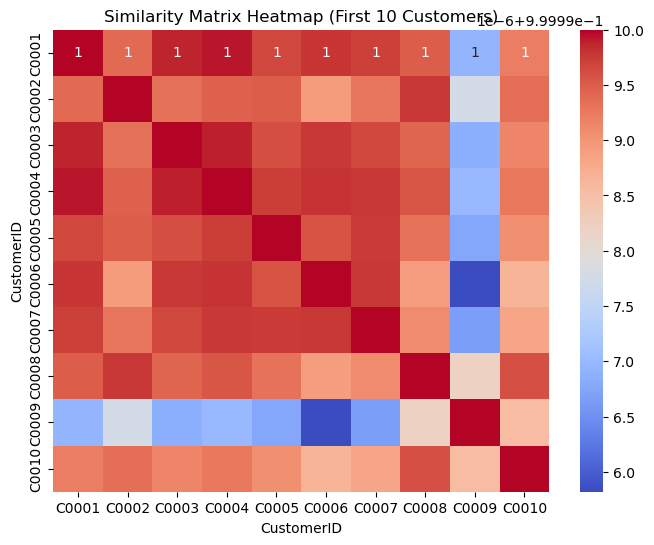

In [9]:
# Heatmap of similarity matrix for the first 10 customers
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df.iloc[:10, :10], annot=True, cmap='coolwarm')
plt.title('Similarity Matrix Heatmap (First 10 Customers)')
plt.show()


## few example recommendations for a few customers

In [10]:
# Showcase example recommendations for a few customers
example_customers = ['C0001', 'C0002', 'C0003']

print("Example Recommendations:")
for cust_id in example_customers:
    print(f"CustomerID: {cust_id}")
    print("Top 3 Similar Customers:")
    for similar_cust, score in lookalike_results[cust_id]:
        print(f"  - {similar_cust} (Similarity Score: {score:.2f})")
    print()


Example Recommendations:
CustomerID: C0001
Top 3 Similar Customers:
  - C0004 (Similarity Score: 1.00)
  - C0108 (Similarity Score: 1.00)
  - C0195 (Similarity Score: 1.00)

CustomerID: C0002
Top 3 Similar Customers:
  - C0084 (Similarity Score: 1.00)
  - C0008 (Similarity Score: 1.00)
  - C0030 (Similarity Score: 1.00)

CustomerID: C0003
Top 3 Similar Customers:
  - C0181 (Similarity Score: 1.00)
  - C0004 (Similarity Score: 1.00)
  - C0108 (Similarity Score: 1.00)



## Results and Deliverables
The top 3 similar customers for each of the first 20 customers (C0001 - C0020) have been generated and saved in `Lookalike.csv`.


In [11]:
# Save recommendations to Lookalike.csv
lookalike_data = []
for cust_id, recommendations in lookalike_results.items():
    lookalike_data.append({'CustomerID': cust_id, 'Recommendations': recommendations})

lookalike_df = pd.DataFrame(lookalike_data)
lookalike_df.to_csv('GUNE_SRINIVAS_Lookalike.csv', index=False)

print("Lookalike recommendations saved to Lookalike.csv.")


Lookalike recommendations saved to Lookalike.csv.


## Conclusion
The Lookalike Model successfully recommends the top 3 most similar customers for the first 20 customers using cosine similarity. The model combines customer profile information and transaction history to generate recommendations, which can be used for personalized marketing strategies. Future enhancements could include:
1. Weighting features based on importance.
2. Incorporating recency and seasonal patterns.
